In [159]:
datadir ='/Users/krithigamurugavel/Downloads/gem5_validation_project/Spring2020/Hardware_values/'

In [160]:
%matplotlib notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

In [161]:
import matplotlib

In [162]:
system_name = ['pcm', 'gem5']

calibrations = ['UnCalib','Calib']

control_cond_benchmarks = ['CCa','CCe','CCm','CCh_st']




In [163]:
#Function to extract stats
def gem5GetStat(filename, stat):
    filename = os.path.join(datadir, '',filename, 'stats.txt').replace('\\','/')
    with open(filename) as f:
        r = f.read()
        if len(r) < 10: return 0.0
        start = r.find(stat) + len(stat) + 1
        end = r.find('#', start)
       # print(r[start:end])
        return float(r[start:end])

In [164]:
#Function to extract stats from PCM
def pcmGetStat(filename, stat):
    filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    with open(filename) as f:
        r = f.read()
        if len(r) < 10: return 0.0
        start = r.find(stat) + len(stat) + 2
        end = r.find('\n', start)
       # print(r[start:end])
        return float(r[start:end])

In [196]:
iters = ['1K','5K']
rows = []
for i in iters:
    for calibs in calibrations:
        for bm in control_cond_benchmarks:
            rows.append([i,calibs,bm,gem5GetStat('control_iter'+'/'+i+'/'+system_name[1]+'/'+calibs+'/'+bm,'sim_ticks')/333, #1000
                           gem5GetStat('control_iter'+'/'+i+'/'+system_name[1]+'/'+calibs+'/'+bm,'sim_insts'),
                           gem5GetStat('control_iter'+'/'+i+'/'+system_name[1]+'/'+calibs+'/'+bm,'sim_ops'),
                           gem5GetStat('control_iter'+'/'+i+'/'+system_name[1]+'/'+calibs+'/'+bm,'host_op_rate'),
                           gem5GetStat('control_iter'+'/'+i+'/'+system_name[1]+'/'+calibs+'/'+bm,'system.cpu.dcache.overall_miss_rate::total'),
                           gem5GetStat('control_iter'+'/'+i+'/'+system_name[1]+'/'+calibs+'/'+bm,'system.cpu.ipc'),
                           gem5GetStat('control_iter'+'/'+i+'/'+system_name[1]+'/'+calibs+'/'+bm,'system.cpu.branchPred.condPredicted'),
                           gem5GetStat('control_iter'+'/'+i+'/'+system_name[1]+'/'+calibs+'/'+bm,'system.cpu.branchPred.condIncorrect'),
                        ])

gem5_df = pd.DataFrame(rows, columns=['itr','Calib','benchmark','cycles', 'instructions', 'ops','host_op_rate', 'overall_missrate',
                                     'ipc','CondPred','CondIndirect'])

gem5_df['Cond_branch_mispred'] = gem5_df['CondIndirect']/gem5_df['CondPred']





In [152]:
rows =[]

#IPC,Branch_total, branch_total_miss,Cond_total,Cond_Miss,Memory_loads_miss, Memory__FB_hits, Total_load_memory,
#RFO_L2hits,RFO_l2miss, Total_store

for i in iters:   
    for bm in control_cond_benchmarks:
        rows.append([i,bm,pcmGetStat('control_iter'+'/'+i+'/'+system_name[0]+'/'+'microbench_all'+'/'+bm, 'IPC'),
                     pcmGetStat('control_iter'+'/'+i+'/'+system_name[0]+'/'+'microbench_all'+'/'+bm,'BRANCH_COND_INSTR_RETIRED_events'),
                     pcmGetStat('control_iter'+'/'+i+'/'+system_name[0]+'/'+'microbench_all'+'/'+bm,'BRANCH_MISSES_RETIRED_events'),  
                    ])
    


pcm_df = pd.DataFrame(rows, columns=['itr','benchmark',
                                     'ipc','CondTotal','CondPred'
                                    ])

pcm_df['Cond_branch_mispred'] =pcm_df['CondPred']/pcm_df['CondTotal']

print(pcm_df)

  itr benchmark      ipc  CondTotal  CondPred  Cond_branch_mispred
0  1K       CCa  1.19030   130681.0     559.0             0.004278
1  1K       CCe  2.22153   259212.0     661.0             0.002550
2  1K       CCm  1.64937   258183.0     576.0             0.002231
3  1K    CCh_st  2.49701   258681.0     553.0             0.002138
4  5K       CCa  1.23427   517684.0    2068.0             0.003995
5  5K       CCe  2.51171  1029683.0    2183.0             0.002120
6  5K       CCm  1.72973  1027681.0    4070.0             0.003960
7  5K    CCh_st  2.74970  1029682.0     453.0             0.000440


In [179]:
##Graph
def doplot_benchmarks(itr,calibrations,benchmarks,benchmark_names,stat_pcm,stat_gem5):
    system = calibrations
    fig,ax = plt.subplots()
    i = 0
    for bm in benchmarks:
        j=0
        d=pcm_df[(pcm_df['benchmark']==bm)&(pcm_df['itr']==itr)]
        ax.bar(i,d[stat_pcm], color='C'+str(j))
        for calib in calibrations:
            g=gem5_df[(gem5_df['benchmark']==bm) &(gem5_df['itr']==itr)&(gem5_df['Calib']==calib)]
            ax.bar(i,g[stat_gem5], color='C'+str(j))
            j=j+1
            i=i+1
        i=i+1
            
    for j,s in enumerate(system):
        ax.bar(0,0,color='C'+str(j), label=s)
    plt.xticks(np.arange(len(benchmark_names))*(len(system)+1)*j/2, benchmark_names, rotation=40, ha='right')

<IPython.core.display.Javascript object>


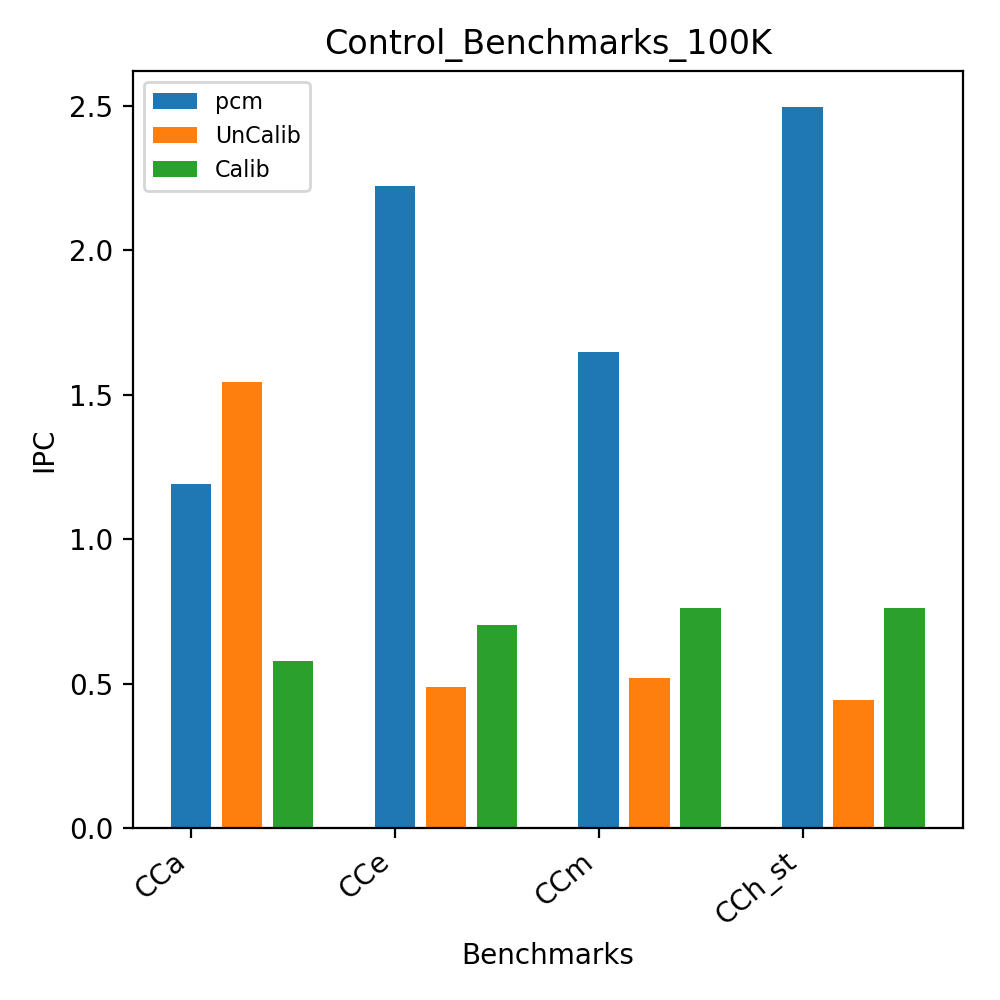

<IPython.core.display.Javascript object>


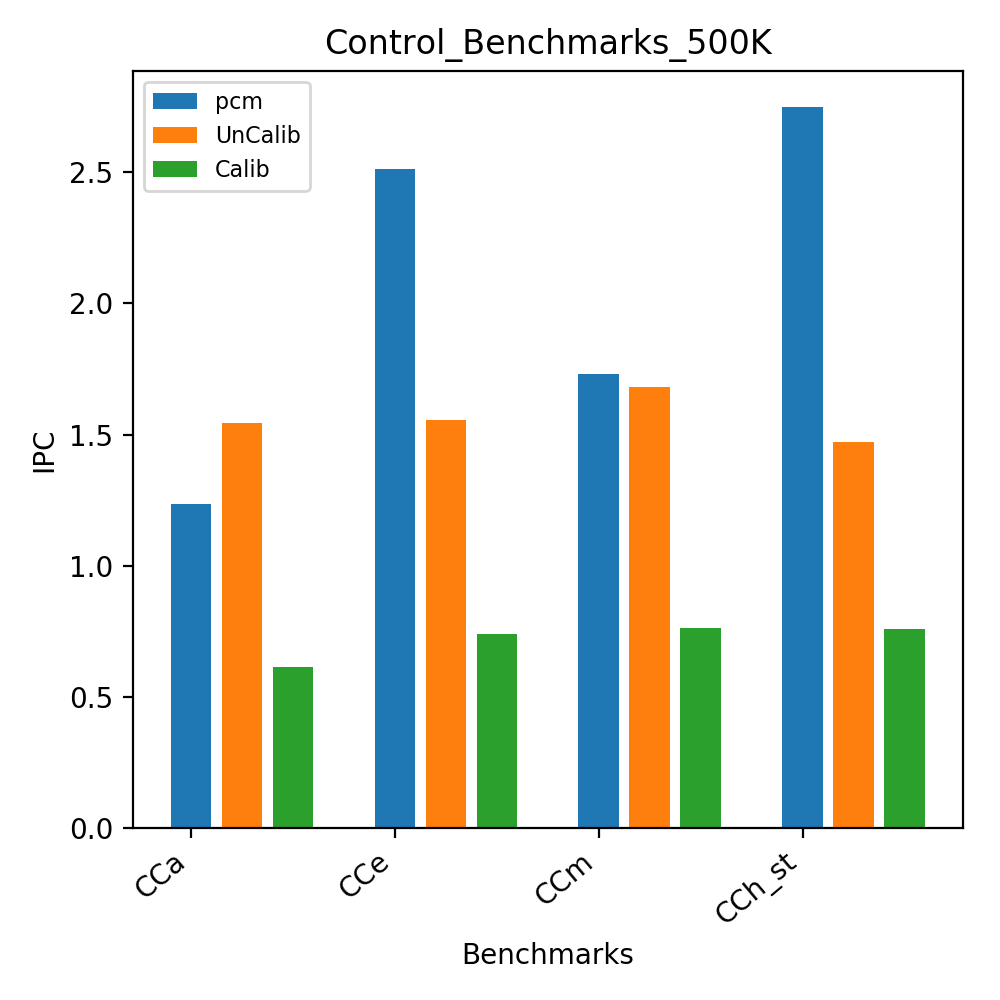

In [187]:
#ipc

benchmarks = control_cond_benchmarks
benchmark_names = control_cond_benchmarks
systems = ['pcm','UnCalib','Calib']
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
doplot_benchmarks('1K',systems,benchmarks,benchmark_names,'ipc','ipc')
plt.ylabel('IPC')
plt.xlabel('Benchmarks')
plt.legend(loc=2, prop={'size': 8})
plt.title('Control_Benchmarks_100K')
plt.tight_layout()
plt.savefig('IPC_cc_calib_hw+gem5_100K.png', format='png', dpi=600)

#ipc 
benchmarks = control_cond_benchmarks
benchmark_names = control_cond_benchmarks
systems = ['pcm','UnCalib','Calib']
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
doplot_benchmarks('5K',systems,benchmarks,benchmark_names,'ipc','ipc')
plt.ylabel('IPC')
plt.xlabel('Benchmarks')
plt.legend(loc=2, prop={'size': 8})
plt.title('Control_Benchmarks_500K')
plt.tight_layout()
plt.savefig('IPC_cc_calib_hw+gem5_500K.png', format='png', dpi=600)

<IPython.core.display.Javascript object>


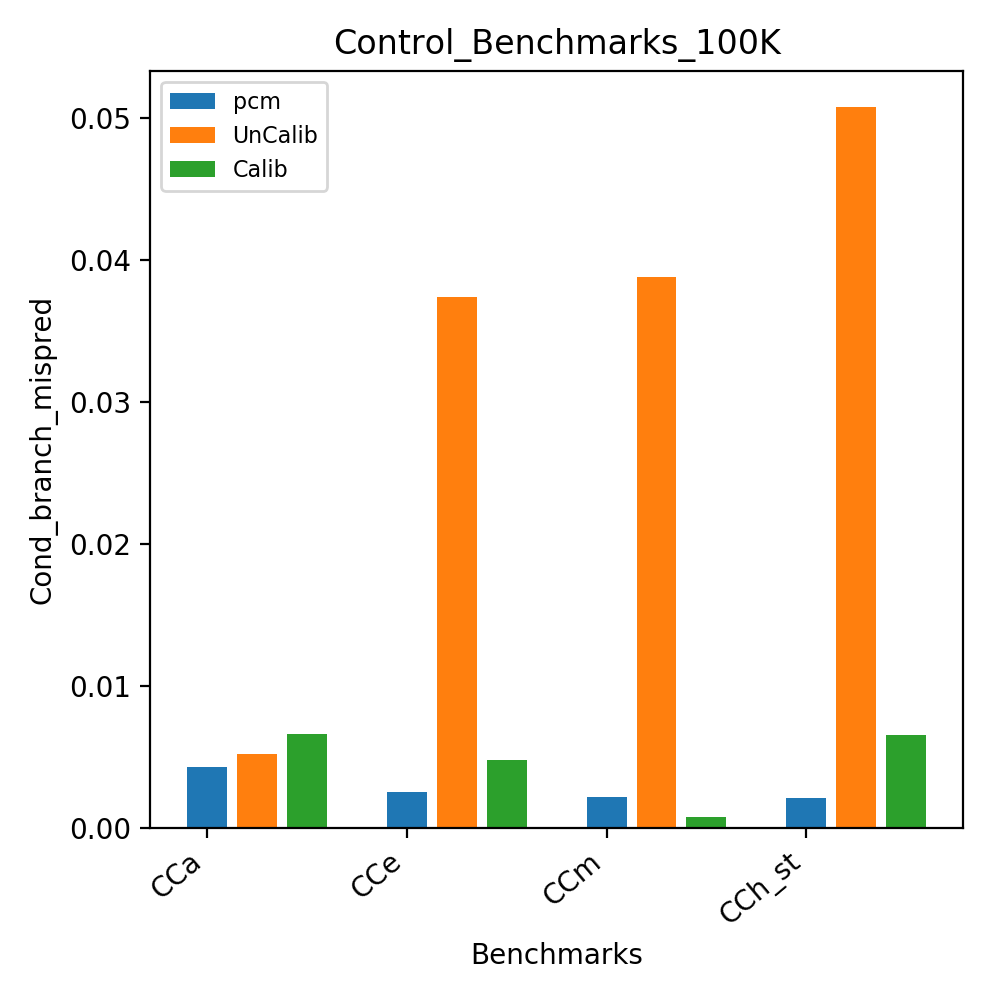

<IPython.core.display.Javascript object>


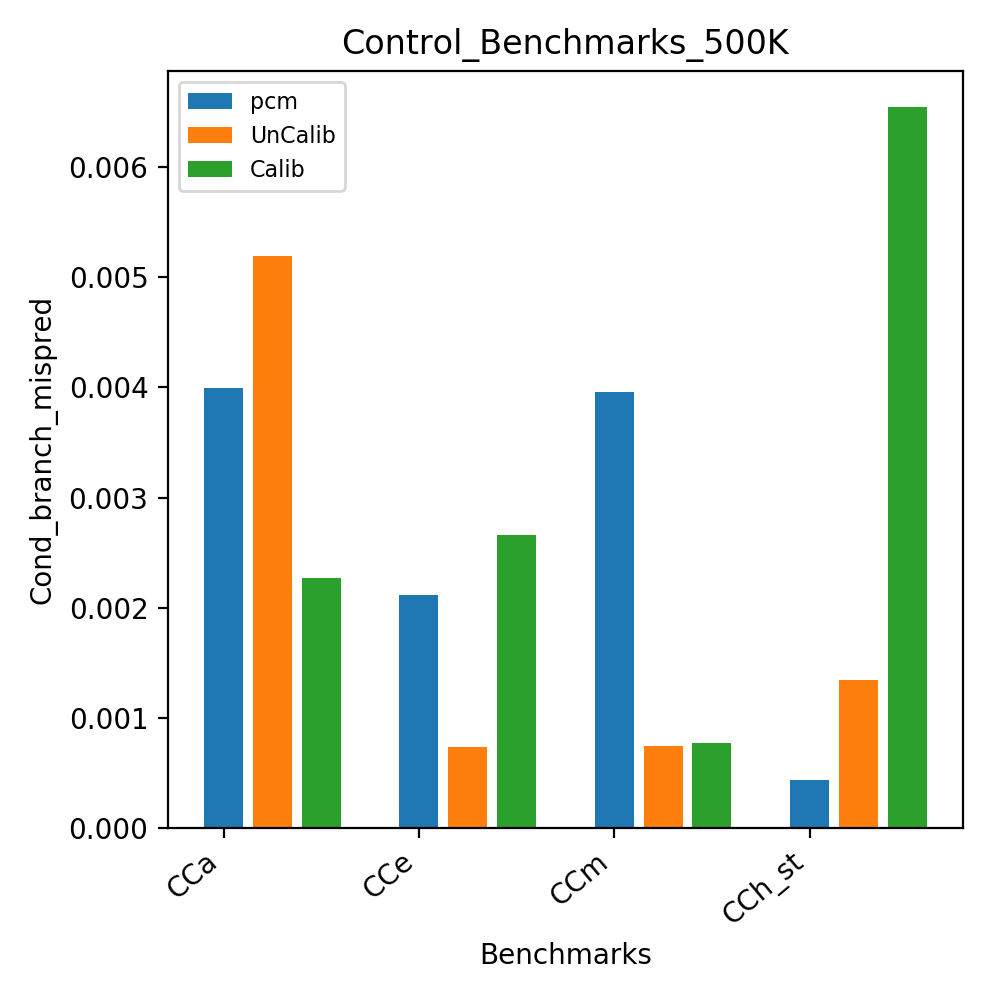

In [185]:
#ipc

benchmarks = control_cond_benchmarks
benchmark_names = control_cond_benchmarks
systems = ['pcm','UnCalib','Calib']
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
doplot_benchmarks('1K',systems,benchmarks,benchmark_names,'Cond_branch_mispred','Cond_branch_mispred')
plt.ylabel('Cond_branch_mispred')
plt.xlabel('Benchmarks')
plt.legend(loc=2, prop={'size': 8})
plt.title('Control_Benchmarks_100K')
plt.tight_layout()
plt.savefig('IPC_cc_calib_hw+gem5_100K.png', format='png', dpi=600)

#ipc 
benchmarks = control_cond_benchmarks
benchmark_names = control_cond_benchmarks
systems = ['pcm','UnCalib','Calib']
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
doplot_benchmarks('5K',systems,benchmarks,benchmark_names,'Cond_branch_mispred','Cond_branch_mispred')
plt.ylabel('Cond_branch_mispred')
plt.xlabel('Benchmarks')
plt.legend(loc=2, prop={'size': 8})
plt.title('Control_Benchmarks_500K')
plt.tight_layout()
plt.savefig('IPC_cc_calib_hw+gem5_500K.png', format='png', dpi=600)